In [1]:
import pandas as pd
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import json
import os
import rasterio
import numpy as np


## cut raster

In [2]:
gdf = gpd.read_file('../konverto_data_package/polygons/polygons.geojson')

In [7]:
gdf1 = gdf.loc[11]
gdf1

type                                                   winery
geometry    MULTIPOLYGON (((673161.0209203674 5138097.8153...
Name: 11, dtype: object

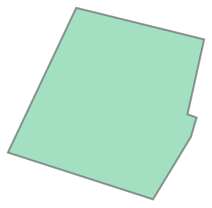

In [27]:
gdf.loc[8].geometry
    

In [5]:
dataset = rasterio.open('../konverto_data_package/climate/tmean/tmean_2020_01_21.tif')
dataset

<open DatasetReader name='../konverto_data_package/climate/tmean/tmean_2020_01_21.tif' mode='r'>

In [16]:
out, inside  = mask(dataset, gdf1[['geometry']], crop=True, invert=False, all_touched=True, nodata=np.nan)
out

array([[[       nan, 0.9553406 ],
        [0.88942724, 0.7424053 ],
        [0.8325057 , 0.34043524]]], dtype=float32)

In [63]:
def get_datasets():

    directory = "../konverto_data_package"
    
    datasets = {}
    for root, dirs, files in os.walk(directory):
        # print(f"Current directory: {root}")
        if "visual" in root:
            continue

        tif_files = [f for f in files if f.endswith(".tif") and not f.startswith(".")]
        tif_paths = [os.path.join(root, f) for f in tif_files]


        if len(tif_files) > 0:

            if "climate" in tif_paths[0]:
                dates = ["-".join(f.replace(".tif", "").split("_")[1:]) for f in tif_files]
            elif "satellite" in tif_paths[0]:
                datestrings = [f.replace(".tif", "").split("_")[0] for f in tif_files]
                dates = [d[:4] + "-" + d[4:6] + "-" + d[6:] for d in datestrings]
            else:
                dates = None
            

            if dates:
                dataset_name = os.path.basename(root)
                
                for date, fp in zip(dates, tif_paths):
                    if date in datasets:
                        datasets[date] |= {dataset_name: fp}
                    else:
                        datasets[date] = {dataset_name: fp}
            
            if "terrain" in tif_paths[0]:
                dataset_names = [n.replace(".tif", "") for n in tif_files]
                for date in datasets.keys():
                    for dn, fp in zip(dataset_names, tif_paths):
                        datasets[date] |= {dn: fp}

                    


    return datasets

In [64]:
datasets = get_datasets()

In [67]:
datasets["2020-03-22"]

{'gdd': '../konverto_data_package\\climate\\gdd\\gdd_2020_03_22.tif',
 'pmm': '../konverto_data_package\\climate\\pmm\\pmm_2020_03_22.tif',
 'tmax': '../konverto_data_package\\climate\\tmax\\tmax_2020_03_22.tif',
 'tmean': '../konverto_data_package\\climate\\tmean\\tmean_2020_03_22.tif',
 'tmin': '../konverto_data_package\\climate\\tmin\\tmin_2020_03_22.tif',
 'ndvi': '../konverto_data_package\\satellite\\indices\\ndvi\\20200322_ndvi.tif',
 'ndwi': '../konverto_data_package\\satellite\\indices\\ndwi\\20200322_ndwi.tif',
 'reci': '../konverto_data_package\\satellite\\indices\\reci\\20200322_reci.tif',
 'elevation': '../konverto_data_package\\terrain\\elevation.tif',
 'exposure': '../konverto_data_package\\terrain\\exposure.tif',
 'slope': '../konverto_data_package\\terrain\\slope.tif'}

In [77]:
def extract_raster_data_from_polygon(polygon, date_string = "2020-03-22"):

    dataset_paths = get_datasets()
    mean = {}
    std = {}
    for dataset_name, fpath in dataset_paths[date_string].items():
        dataset = rasterio.open(fpath)
        mean[dataset_name] = np.nanmean(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])
        std[dataset_name] = np.nanstd(mask(dataset, polygon, crop=True, invert=False, all_touched=True, nodata=np.nan)[0])

    return mean, std

In [80]:
data_2020_03_22 = extract_raster_data_from_polygon(gdf.loc[8][['geometry']], "2020-03-22")

In [81]:
mean__2020_03_22, std_2020_03_22 = data_2020_03_22

In [82]:
mean__2020_03_22

{'gdd': 3.0514283,
 'pmm': 0.5240816,
 'tmax': 18.79458,
 'tmean': 12.797966,
 'tmin': 7.3100734,
 'ndvi': 0.200307,
 'ndwi': -0.0628448,
 'reci': 0.5023746,
 'elevation': 234.68951,
 'exposure': 117.24225,
 'slope': 13.417278}

In [83]:
std_2020_03_22

{'gdd': 0.07790624,
 'pmm': 0.00042274912,
 'tmax': 0.10280419,
 'tmean': 0.067894556,
 'tmin': 0.065944,
 'ndvi': 0.019187992,
 'ndwi': 0.014411566,
 'reci': 0.05902372,
 'elevation': 5.725454,
 'exposure': 7.238578,
 'slope': 3.045035}